In [45]:
from matplotlib import pyplot
pyplot.rc("figure", figsize=(30, 30))

In [2]:
# параметры робота
# улавливает расстояния от 0 до 9.5 метров 
# # адекватнее: от 0.5 = это расстояние от центра до края (кстати, когда расстояние РАВНО 0.5, это плохо, потому что мы врезались)
# угол обзора лидара 360 градусов

In [3]:
# входы
# угол м-у осью робота и препятствием (alpha) (градусы)
# расстояние между центром робота и препятствием (s) (м)
# скорость робота (линейная) (v) (м/c)

# в первую очередь судить по alpha
# если s <= 0.5, то мы УЖЕ врезались

In [123]:
from fuzzylogic.classes import Domain
from fuzzylogic.functions import gauss, bounded_sigmoid, S, trapezoid, R

# domains
alpha_to_obstacle = Domain("Angle between the robot and an obstacle", 0, 360)
s = Domain("Distance between the robot and an obstacle", 0.5, 9.5)
v = Domain("Current linear speed of the robot (m/s)", 0, 10)

# sets = сделать категории и присвоить им функции принадлежности (NB: моё понимание может быть некорректным)

# alpha
# 0-45 нужно подумать
# 45-135 высокий риск врезаться
# 135-180 нужно подумать
# 180-360 препятствие позади, оно нам безразлично

alpha_to_obstacle.average_danger_left_side = bounded_sigmoid(0, 30, inverse=True)
# чтобы максимум y доходил до единицы 
alpha_to_obstacle.average_danger_left_side = alpha_to_obstacle.average_danger_left_side.normalized()

# x-координата пика была подобрана методом научного тыка
# область высокой опасности такая большая, чтобы перестраховаться
alpha_to_obstacle.high_danger = gauss(85, 0.001, c_m=1)

# 135 + (180-135)/2 = 135 + 45/2 = 135 + 22.5
alpha_to_obstacle.average_danger_right_side = gauss(157.5, 0.007, c_m=1)

alpha_to_obstacle.low_danger = bounded_sigmoid(180, 200, inverse=False)
alpha_to_obstacle.low_danger = alpha_to_obstacle.low_danger.normalized()

# s
# категории: близко, средне, далеко
s.close = bounded_sigmoid(0.5, 1.5, inverse=True)
s.close = s.close.normalized()
s.average = gauss(2.5, 1.5, c_m=1)
s.far = bounded_sigmoid(4, 7, inverse=False)
s.far = s.far.normalized()

# v
# категории: медленно, средне, быстро
v.slow = bounded_sigmoid(0, 0.3, inverse=True)
v.slow = v.slow.normalized()
v.average = gauss(3, 1, c_m=1)
v.fast = bounded_sigmoid(5, 6, inverse=False)
v.fast = v.fast.normalized()

'\n# s\n# категории: близко, средне, далеко\ns.close = S(0.5, 1)\ns.average = trapezoid(0.6, 0.7, 4.5, 5)\ns.far = R(4.8, 9.5)\n\n# v\n# категории: очень медленно, медленно, средне, быстро\nv.very_slow = S(0, 1)\nv.slow = trapezoid(0.5, 0.6, 0.7, 0.9)\nv.average = trapezoid(0.8, 1, 3, 6)\nv.fast = R(5.8, 8)\n'

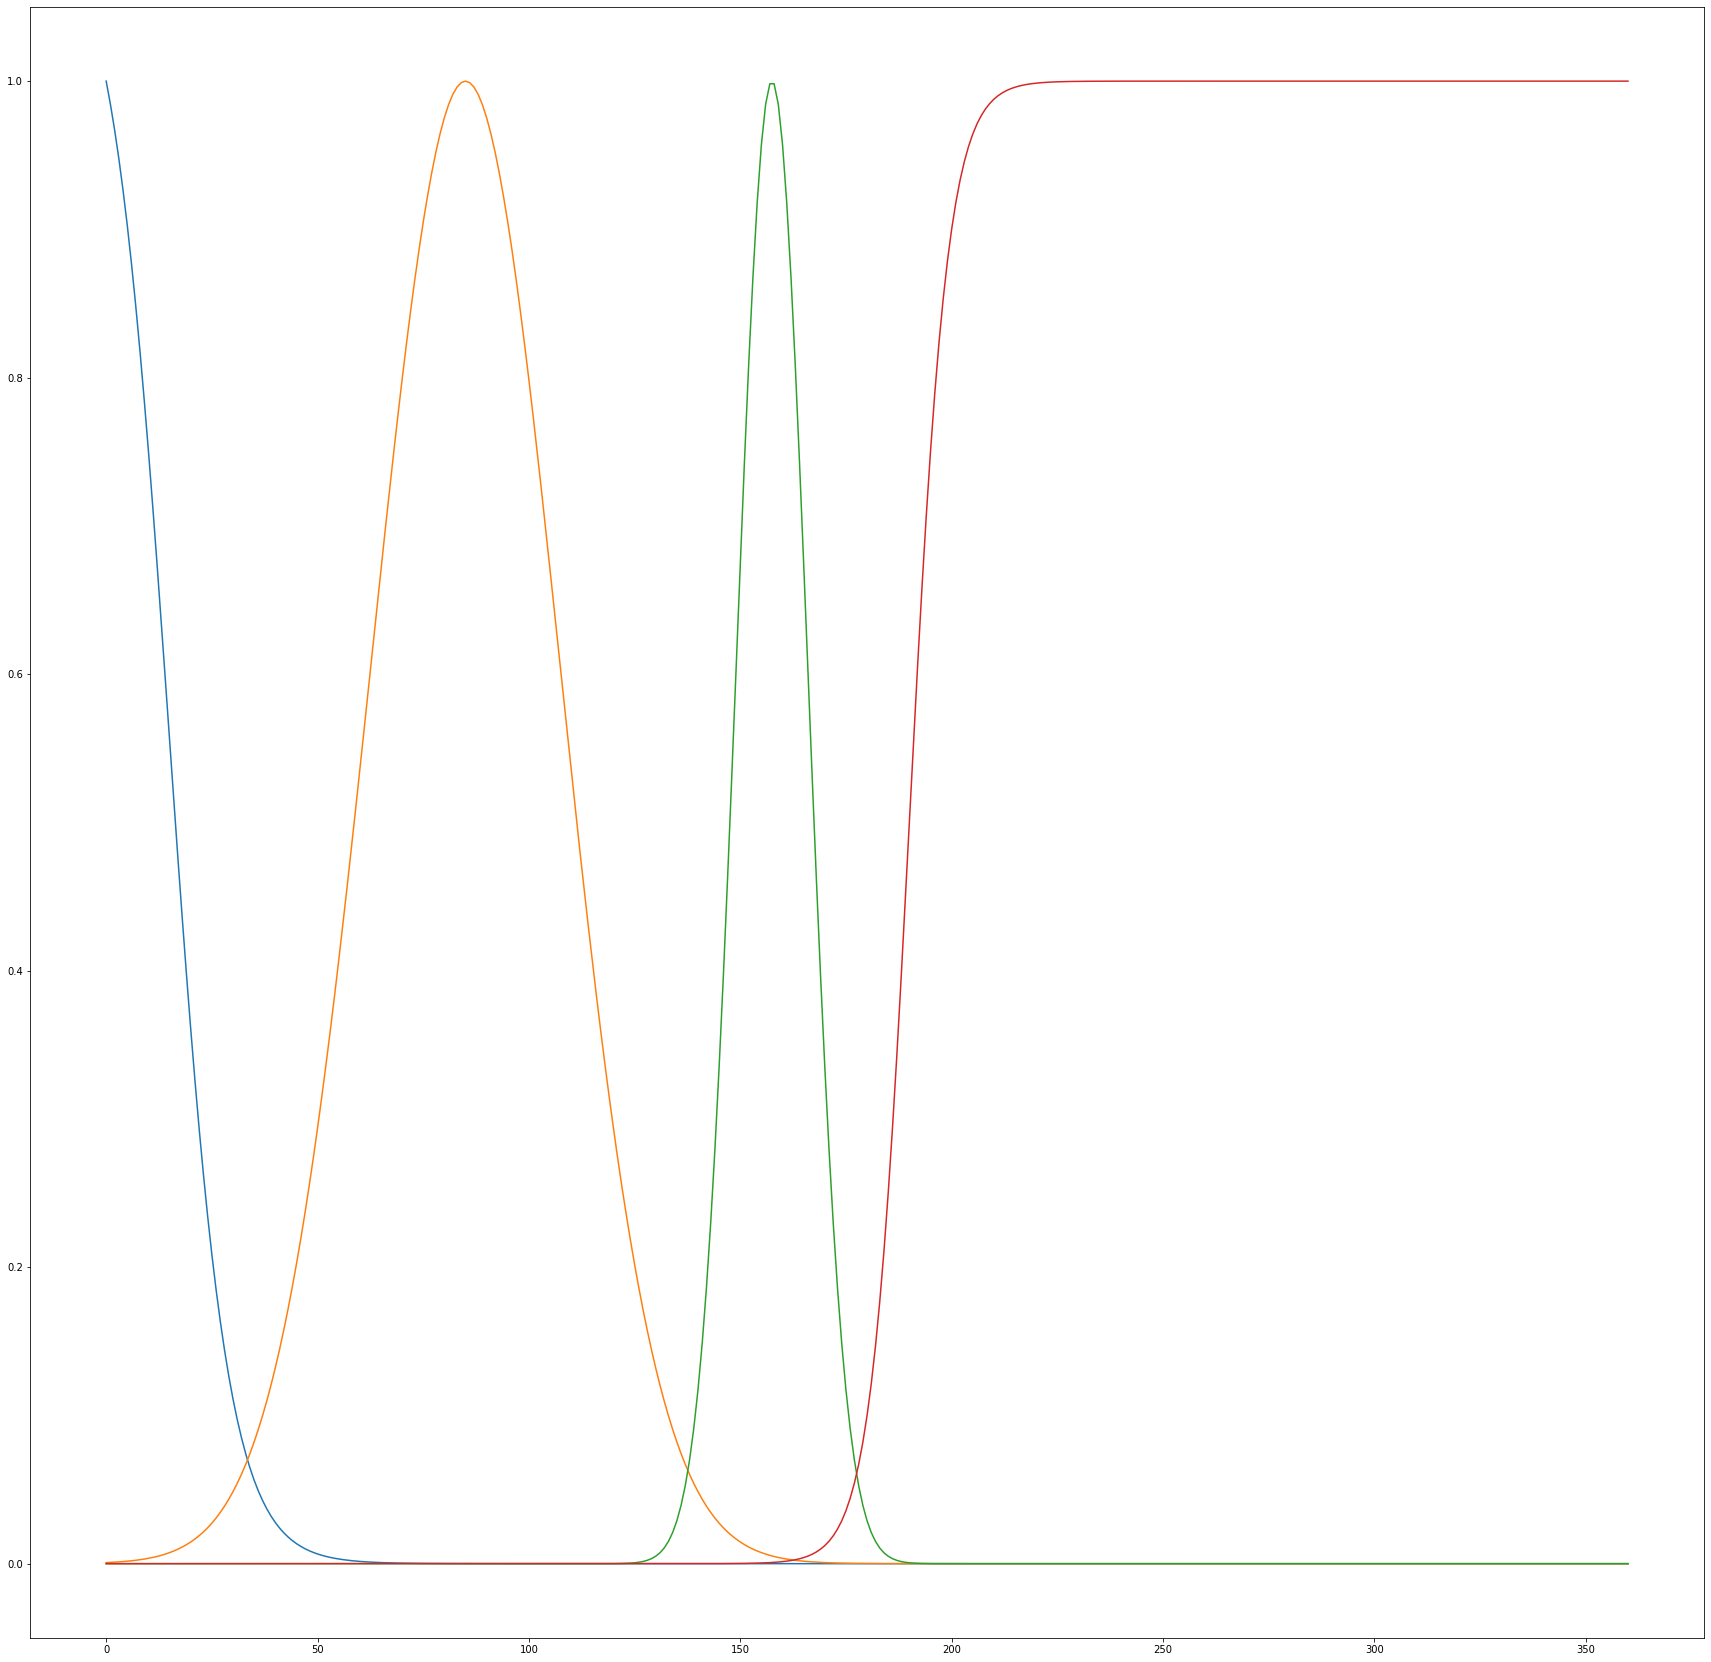

In [100]:
alpha_to_obstacle.average_danger_left_side.plot()
alpha_to_obstacle.high_danger.plot()
alpha_to_obstacle.average_danger_right_side.plot()
alpha_to_obstacle.low_danger.plot()

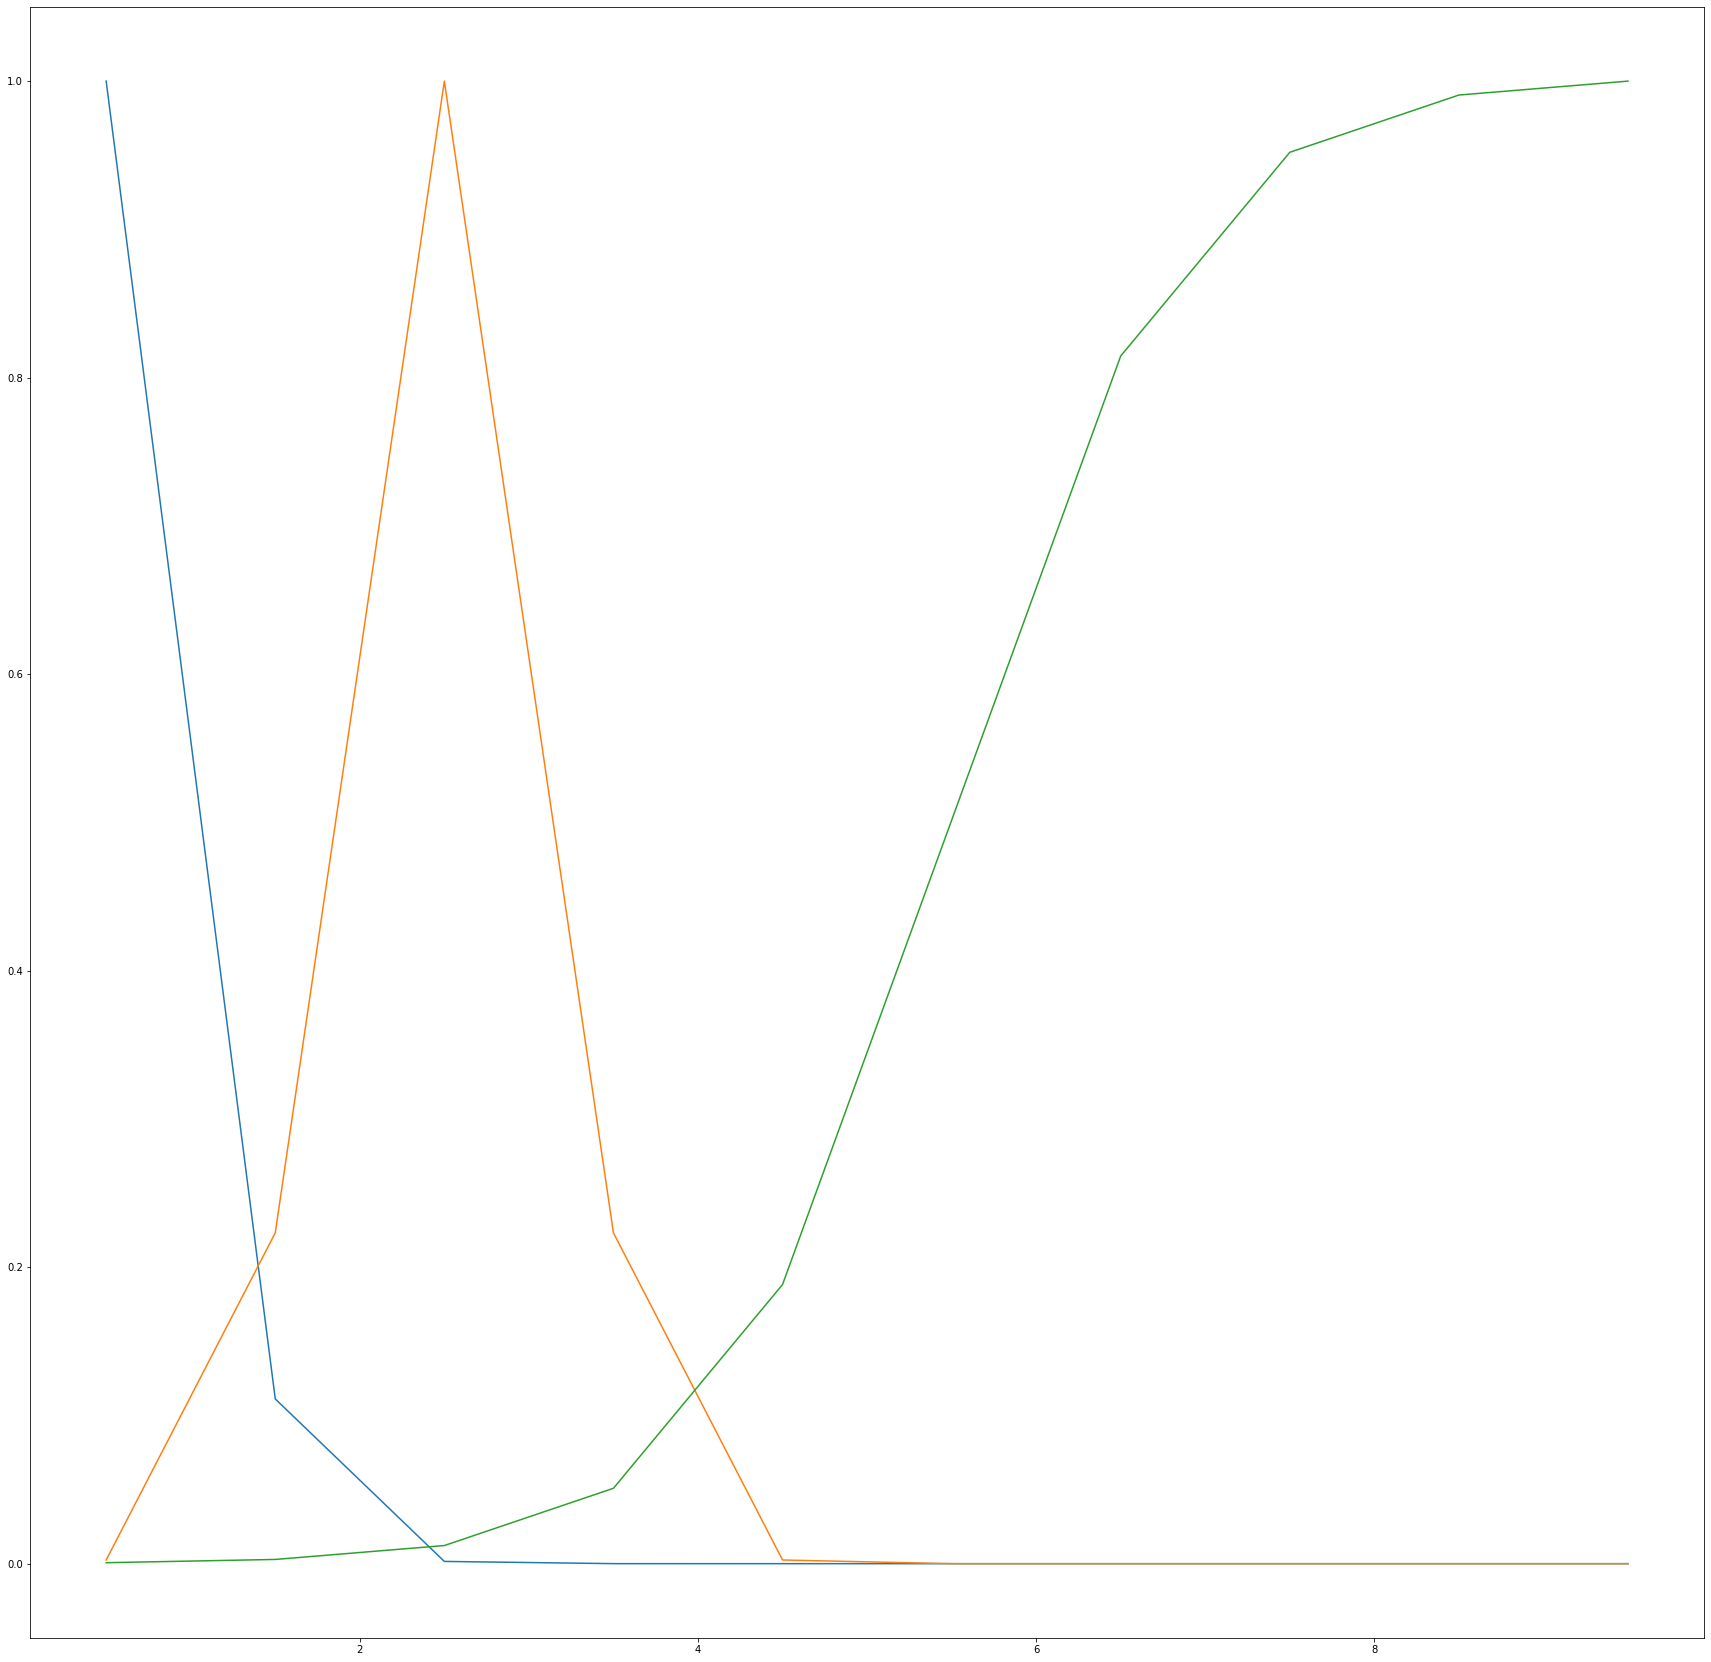

In [112]:
s.close.plot()
s.average.plot()
s.far.plot()

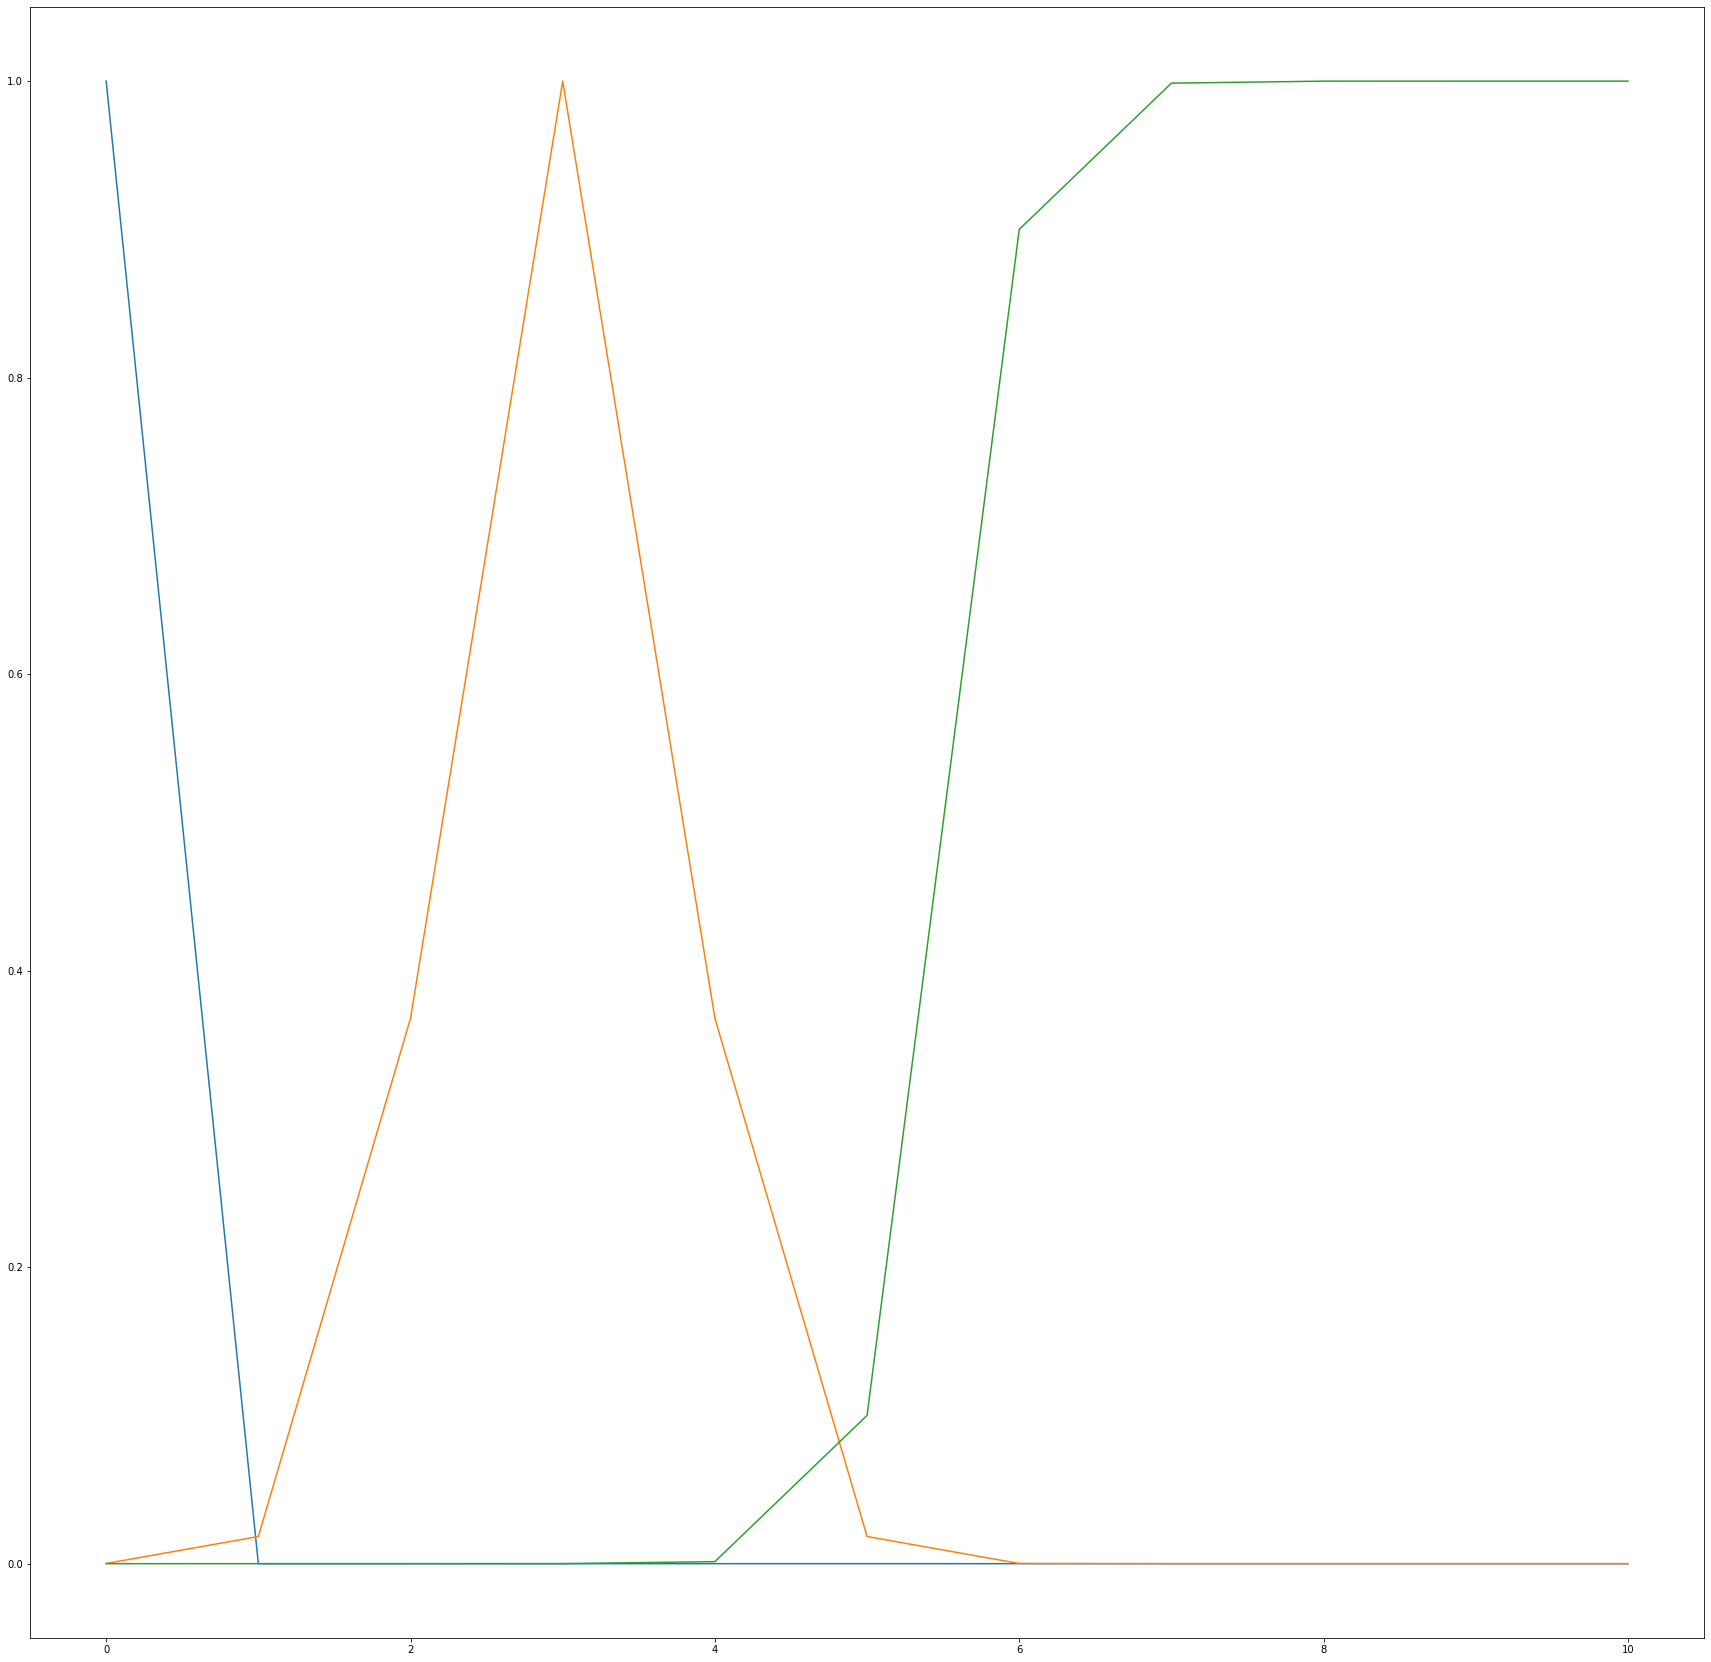

In [124]:
v.slow.plot()
v.average.plot()
v.fast.plot()

In [29]:
# выходы
# целевой угол (куда повернётся робот) (gamma) (градусы)
# # насколько я понимаю, целевой угол -- это не "НА СКОЛЬКО градусов надо повернуть колесо относительно текущего положения", а "какое должно быть новое положение колеса с
# # точки зрения угла"
# # # в таком случае нужно как-то прикинуть оценку, сколько времени поворот будет занимать (успеем ли)
# # # или забить?
# скорость робота (линейная) (v) (м/c)

In [135]:
# gamma
# категории: мало, много
gamma = Domain("New angle", 0, 90)
gamma.low = bounded_sigmoid(0, 35, inverse=True)
gamma.low = gamma.low.normalized()
gamma.high = bounded_sigmoid(25, 70, inverse=False)
gamma.high = gamma.high.normalized()

# new_v
# категории: медленно, средне, быстро
new_v = Domain("New speed (m/s)", 0, 10)
new_v.low = bounded_sigmoid(0, 0.5, inverse=True)
new_v.low = new_v.low.normalized()
new_v.average = gauss(2, 1, c_m=1)
new_v.fast = bounded_sigmoid(4, 5, inverse=False)
new_v.fast = new_v.fast.normalized()

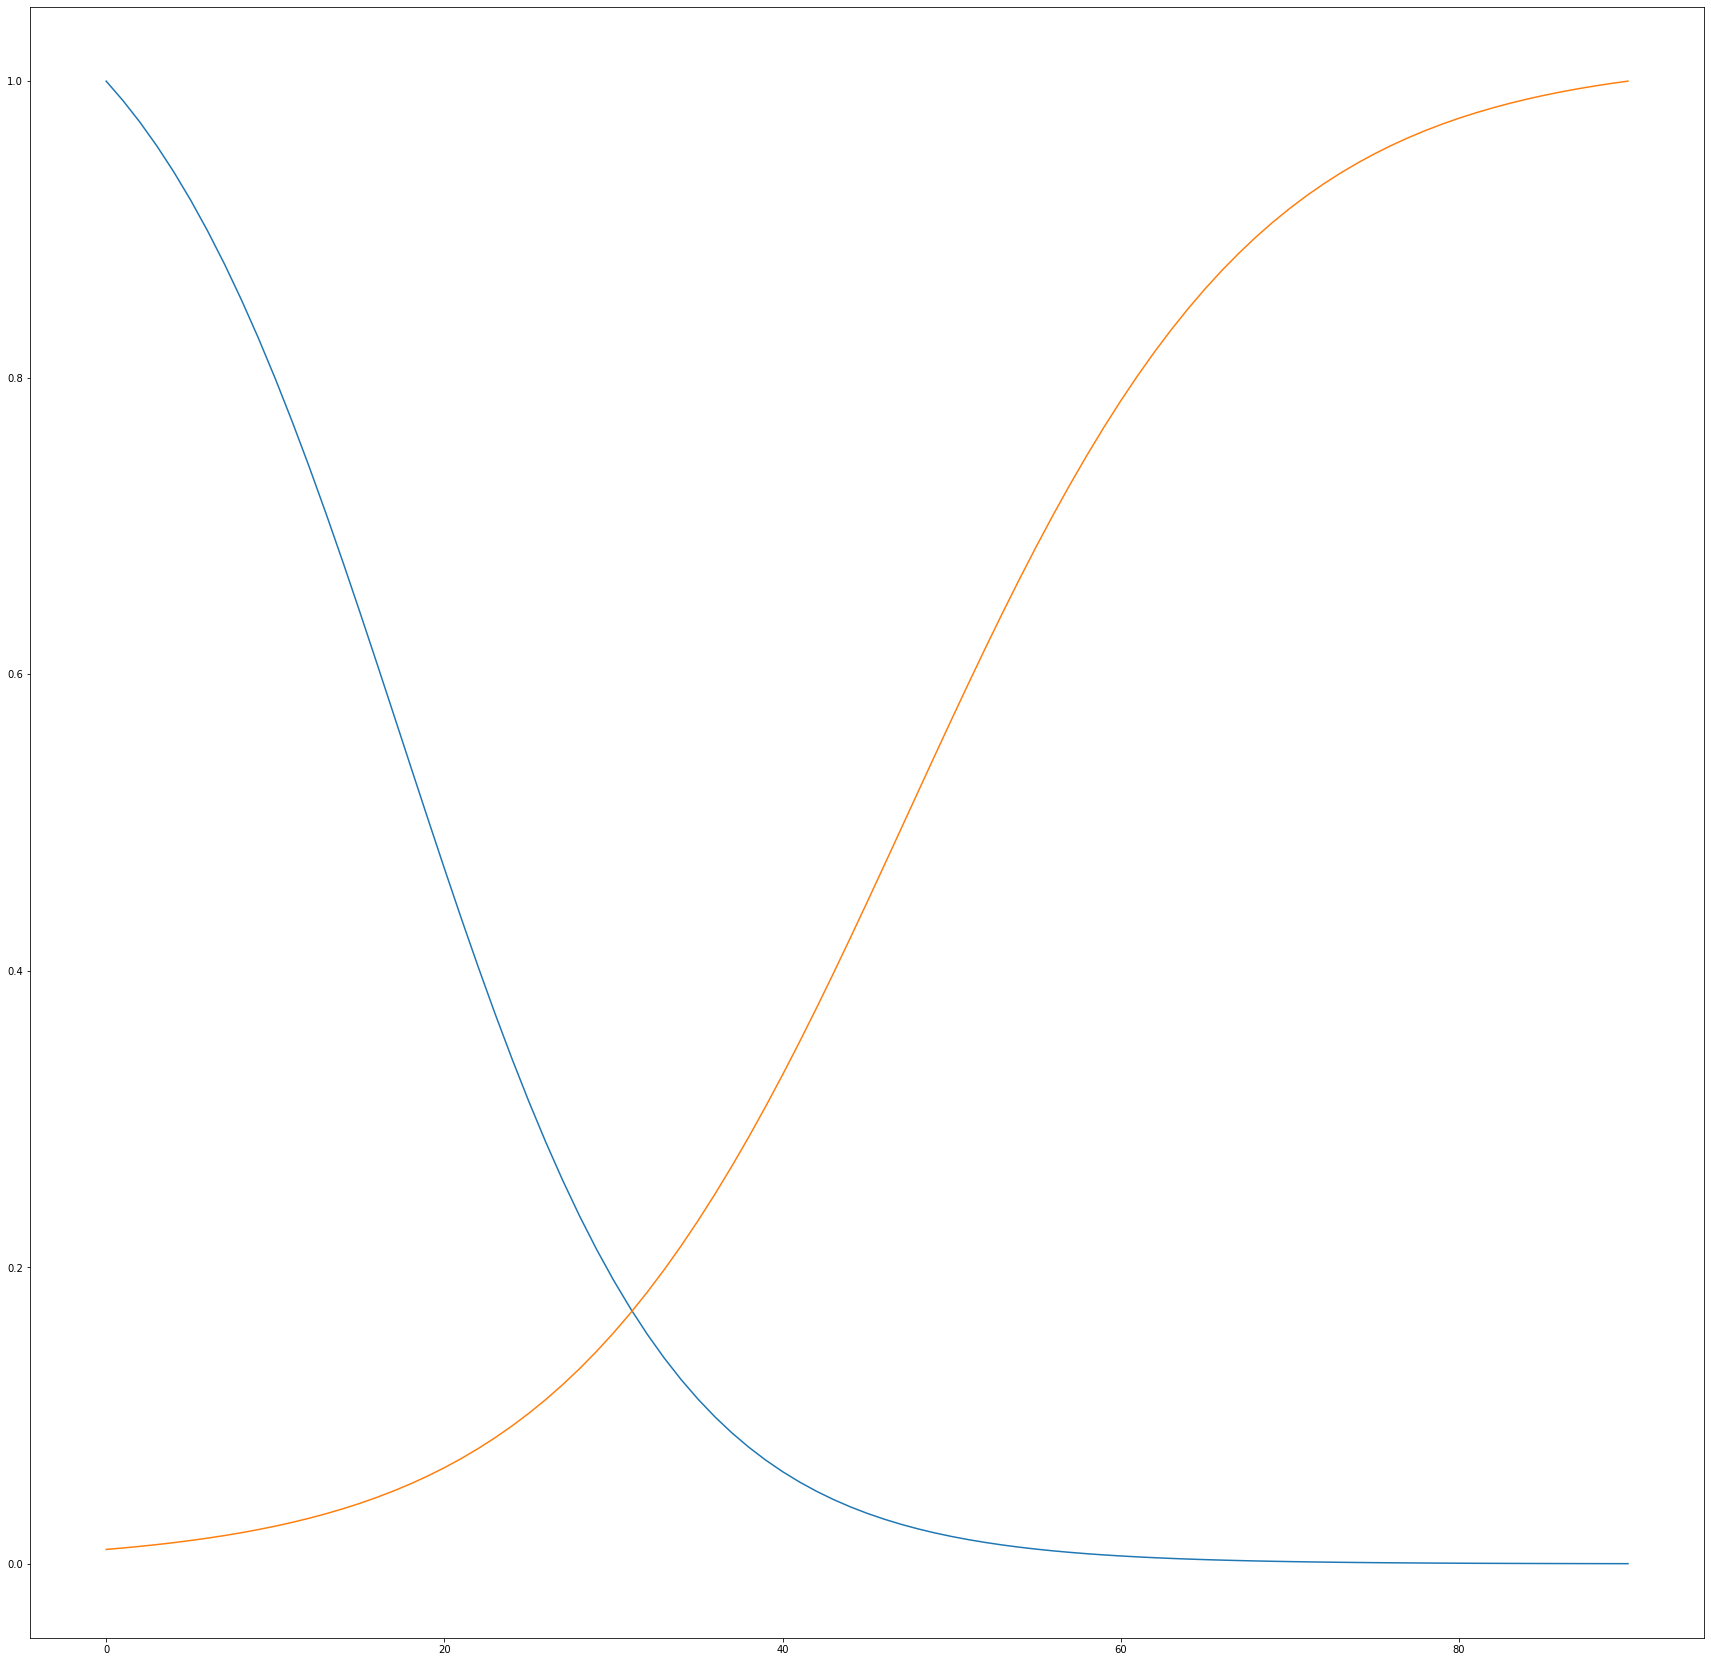

In [134]:
gamma.low.plot()
gamma.high.plot()

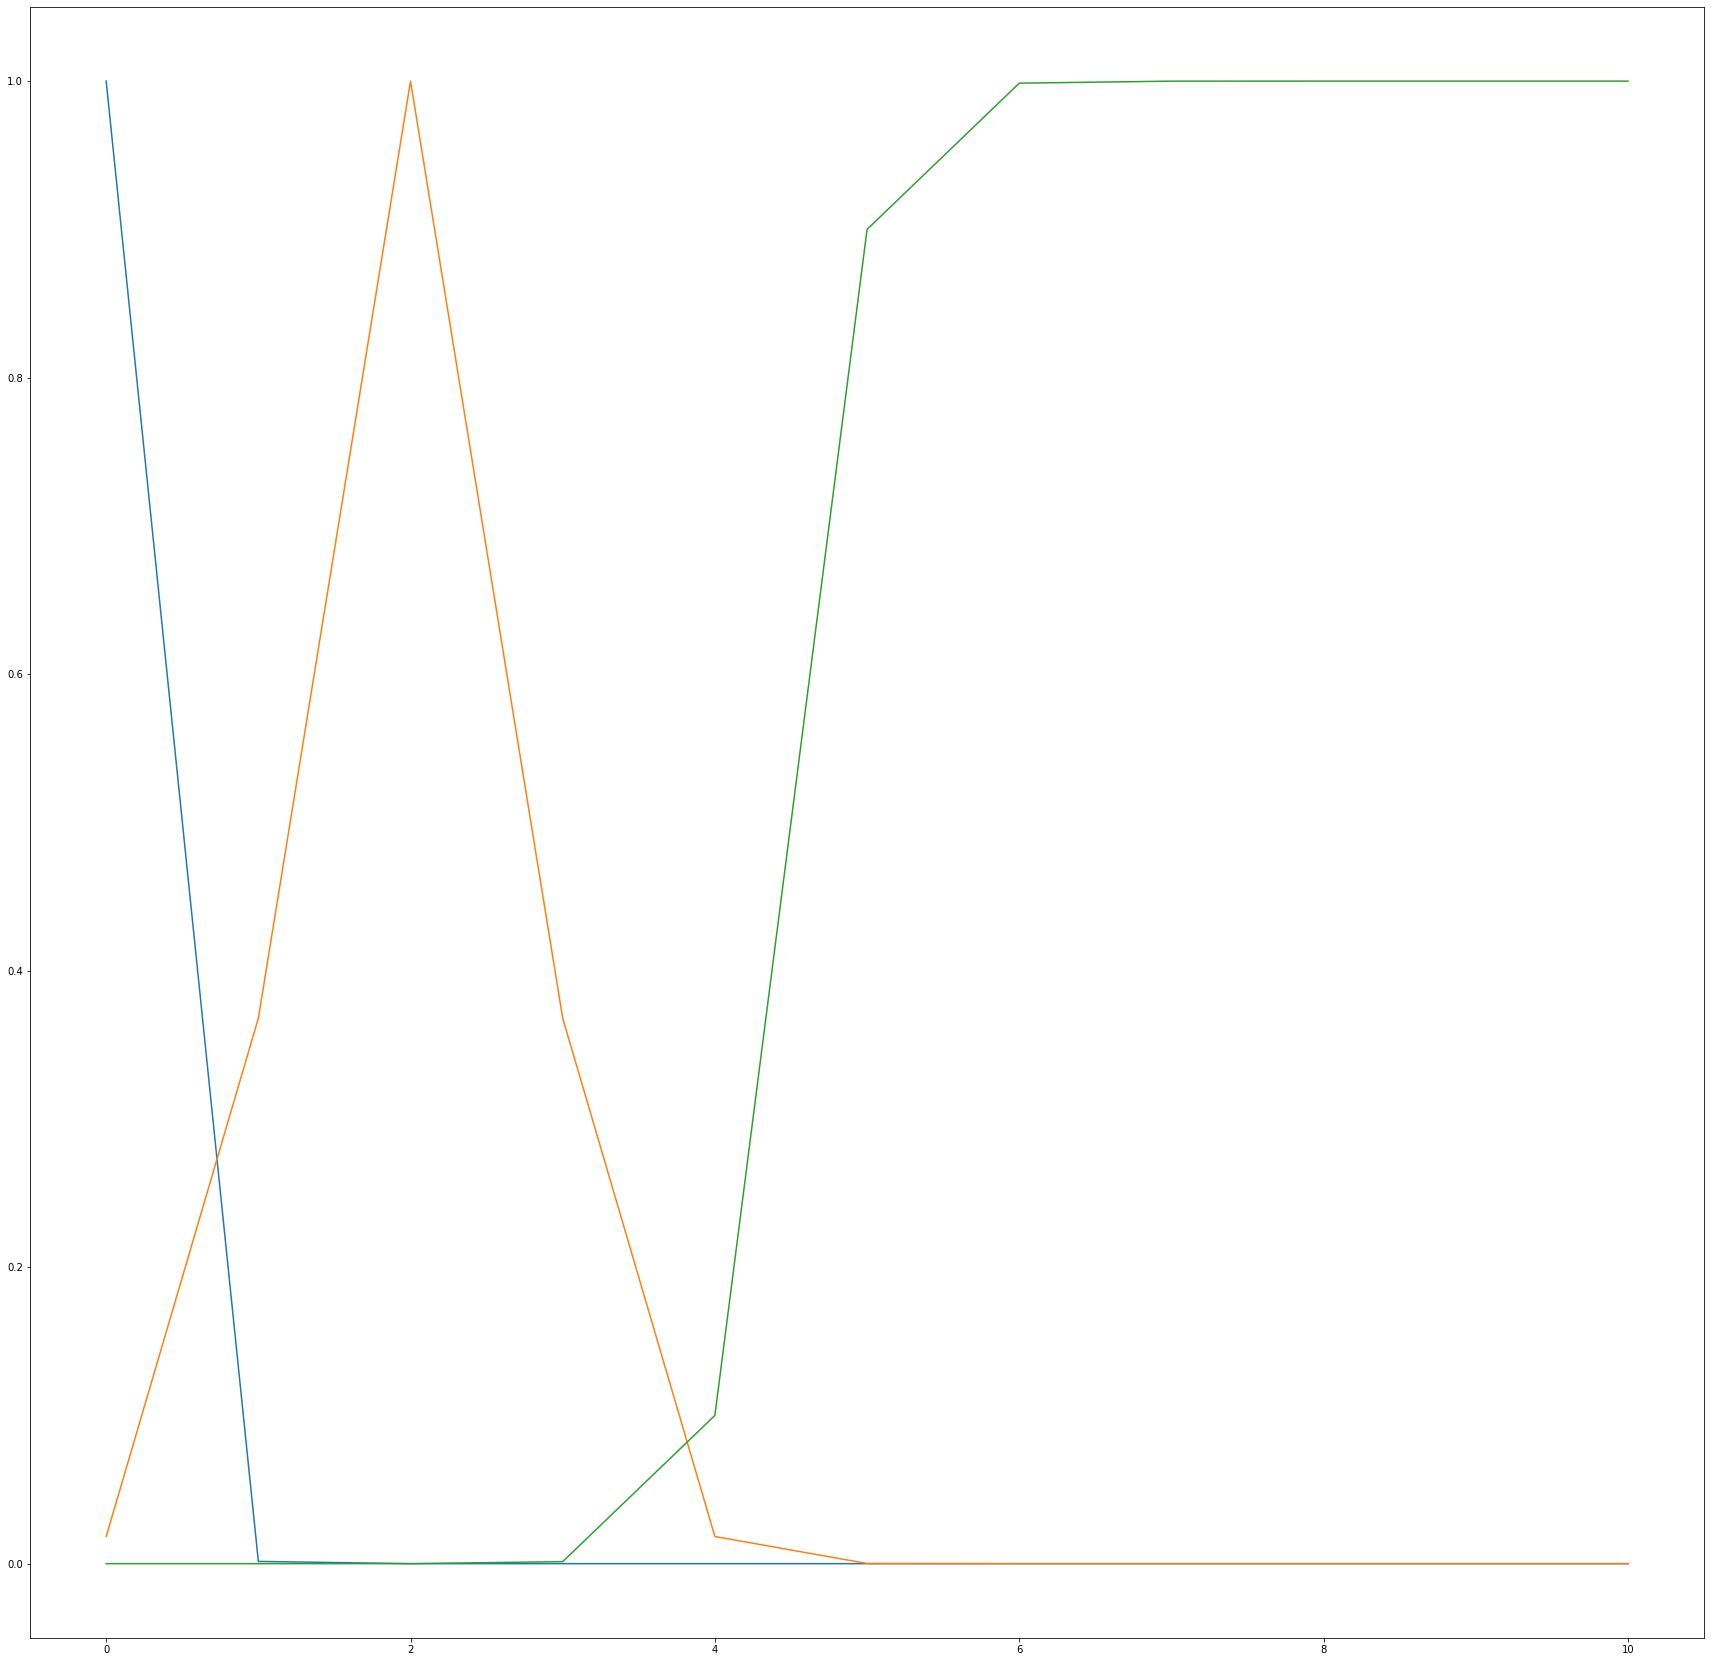

In [137]:
new_v.low.plot()
new_v.average.plot()
new_v.fast.plot()

Вспомогательная секция (при желании можно проигнорить)

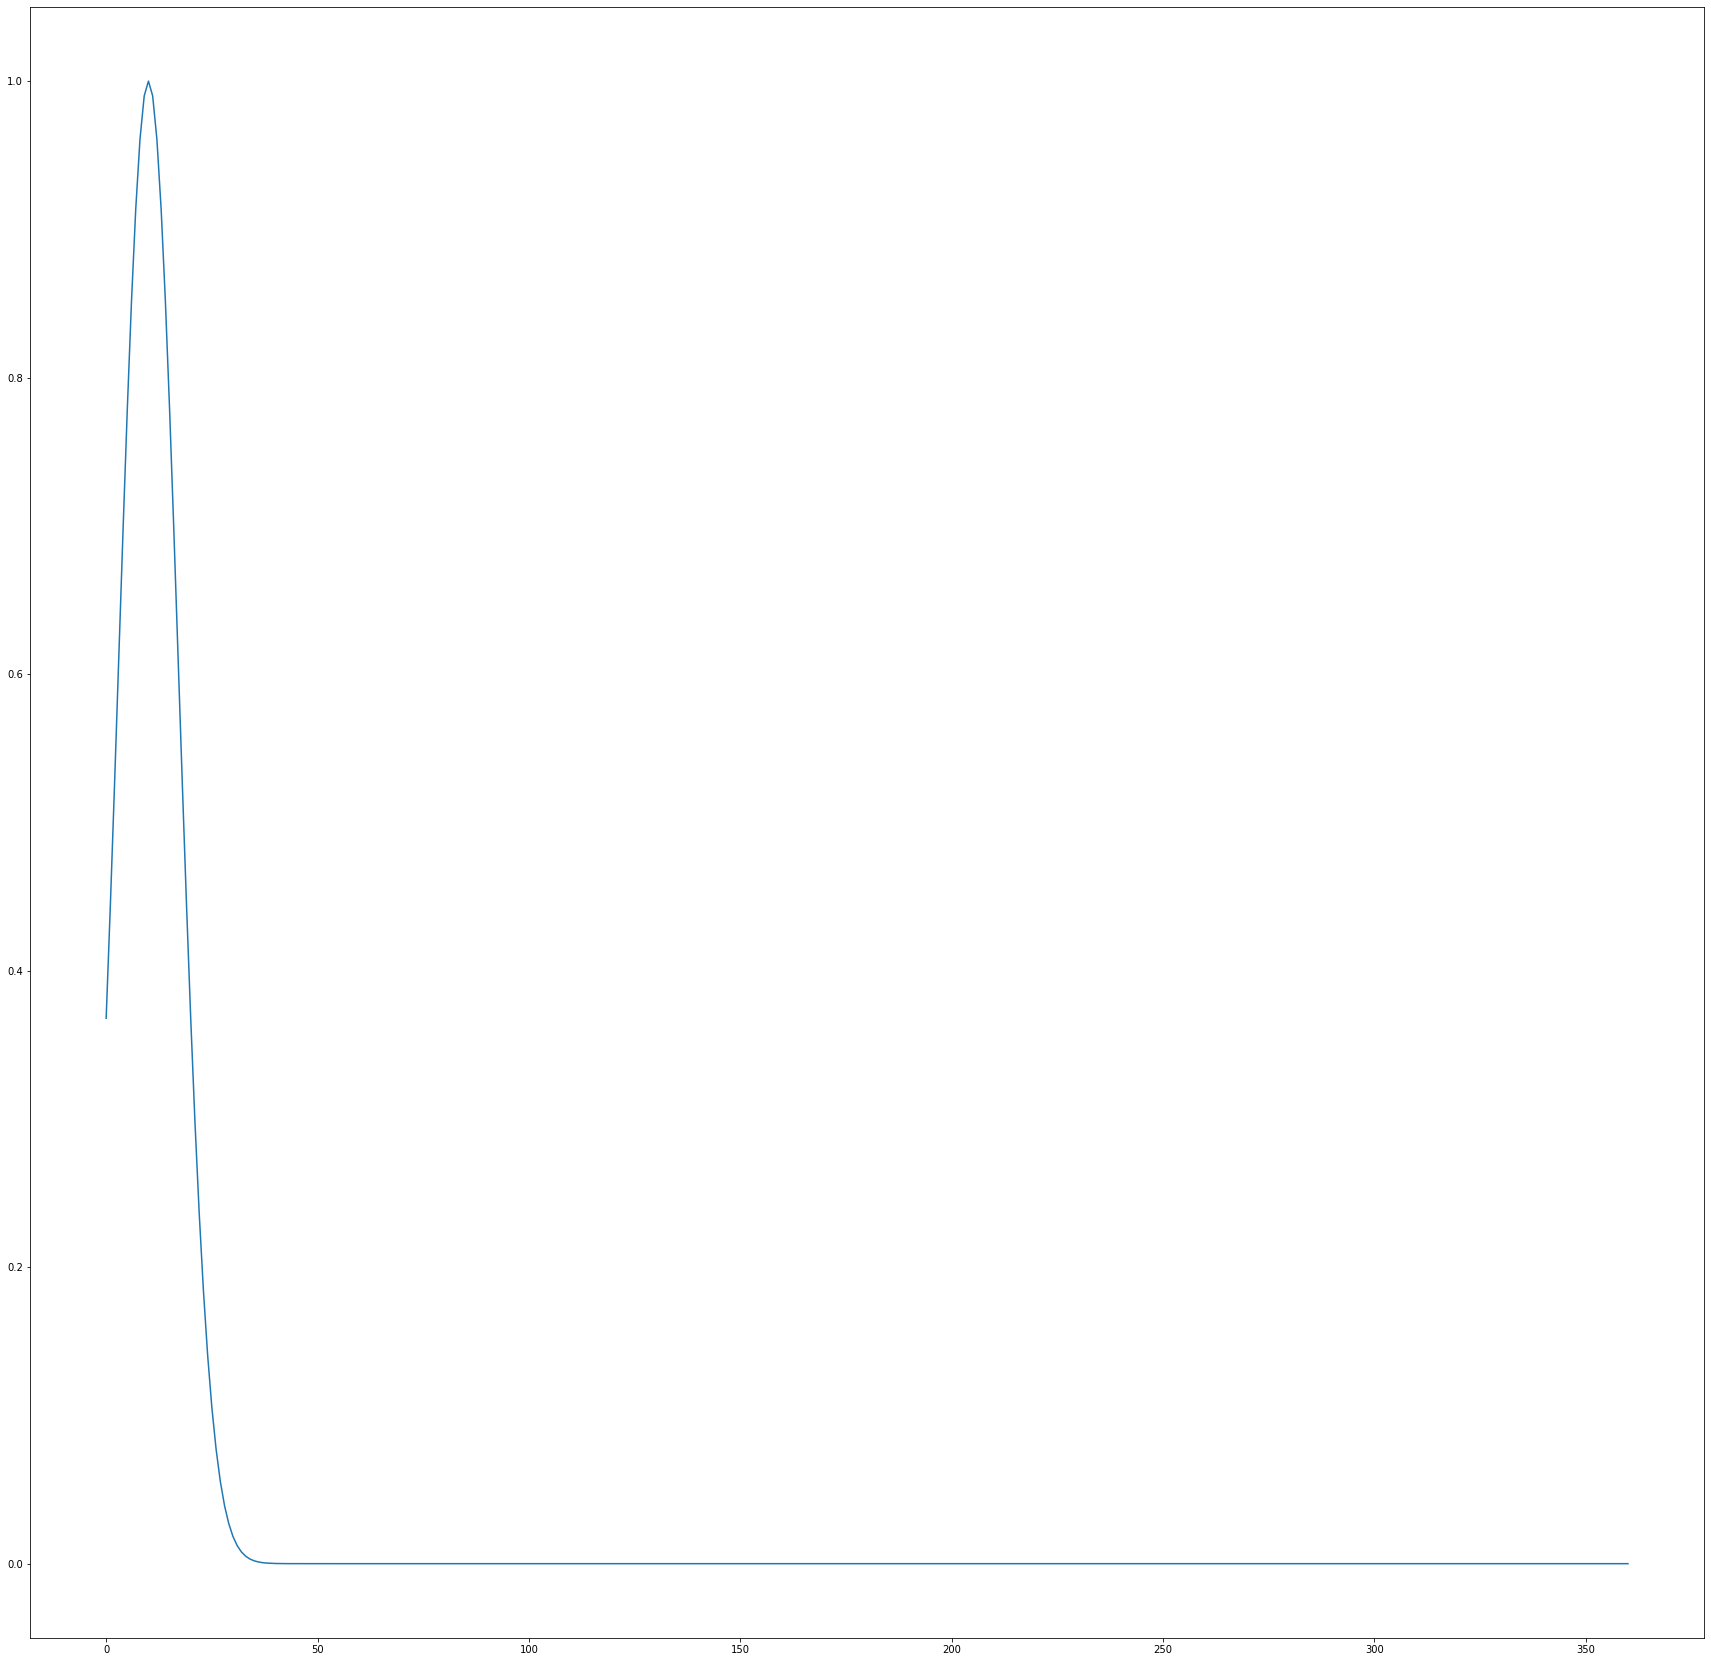

In [10]:
# вспомогательная секция
# про подачу аргументов в gauss
# первое число сделать больше -- пик едет вправо
# второе число сделать меньше -- график шире; сделать больше -- график уже
# c_m = высота пика (какая у графика наибольшая по y точка)
alpha_to_obstacle.dangerously_close = gauss(10, 0.01, c_m=1)
alpha_to_obstacle.dangerously_close.plot()

In [31]:
# отвергнутые варианты
# почему отвергнуты: 1) в пользу нормального распределения, так как чувствуется, как что-то, что больше подходит 
# 2) более равномерно распределить графики
# если от 45 до 135, то высокий риск врезаться
# если от 0 до 45 или от 135 до 180, то нужно подумать
# если от 180 до 360, то препятствие сзади, оно нам безразлично
alpha_to_obstacle.average_danger_left_side = S(0, 45)
# начинается не с 45, чтобы пересечение c average_danger_left_side не было нулевым 
# заканчивается не с 135, чтобы пересечение c average_danger_кшпре_side не было нулевым
alpha_to_obstacle.high_danger = trapezoid(35, 60, 120, 145, c_m=1)
alpha_to_obstacle.average_danger_right_side = trapezoid(135, 140, 165, 190, c_m=1)
alpha_to_obstacle.low_danger = R(180, 360)

# s
# категории: близко, средне, далеко
s.close = S(0.5, 1)
s.average = trapezoid(0.6, 0.7, 4.5, 5)
s.far = R(4.8, 9.5)

# v
# категории: очень медленно, медленно, средне, быстро
v.very_slow = S(0, 1)
v.slow = trapezoid(0.5, 0.6, 0.7, 0.9)
v.average = trapezoid(0.8, 1, 3, 6)
v.fast = R(5.8, 8)

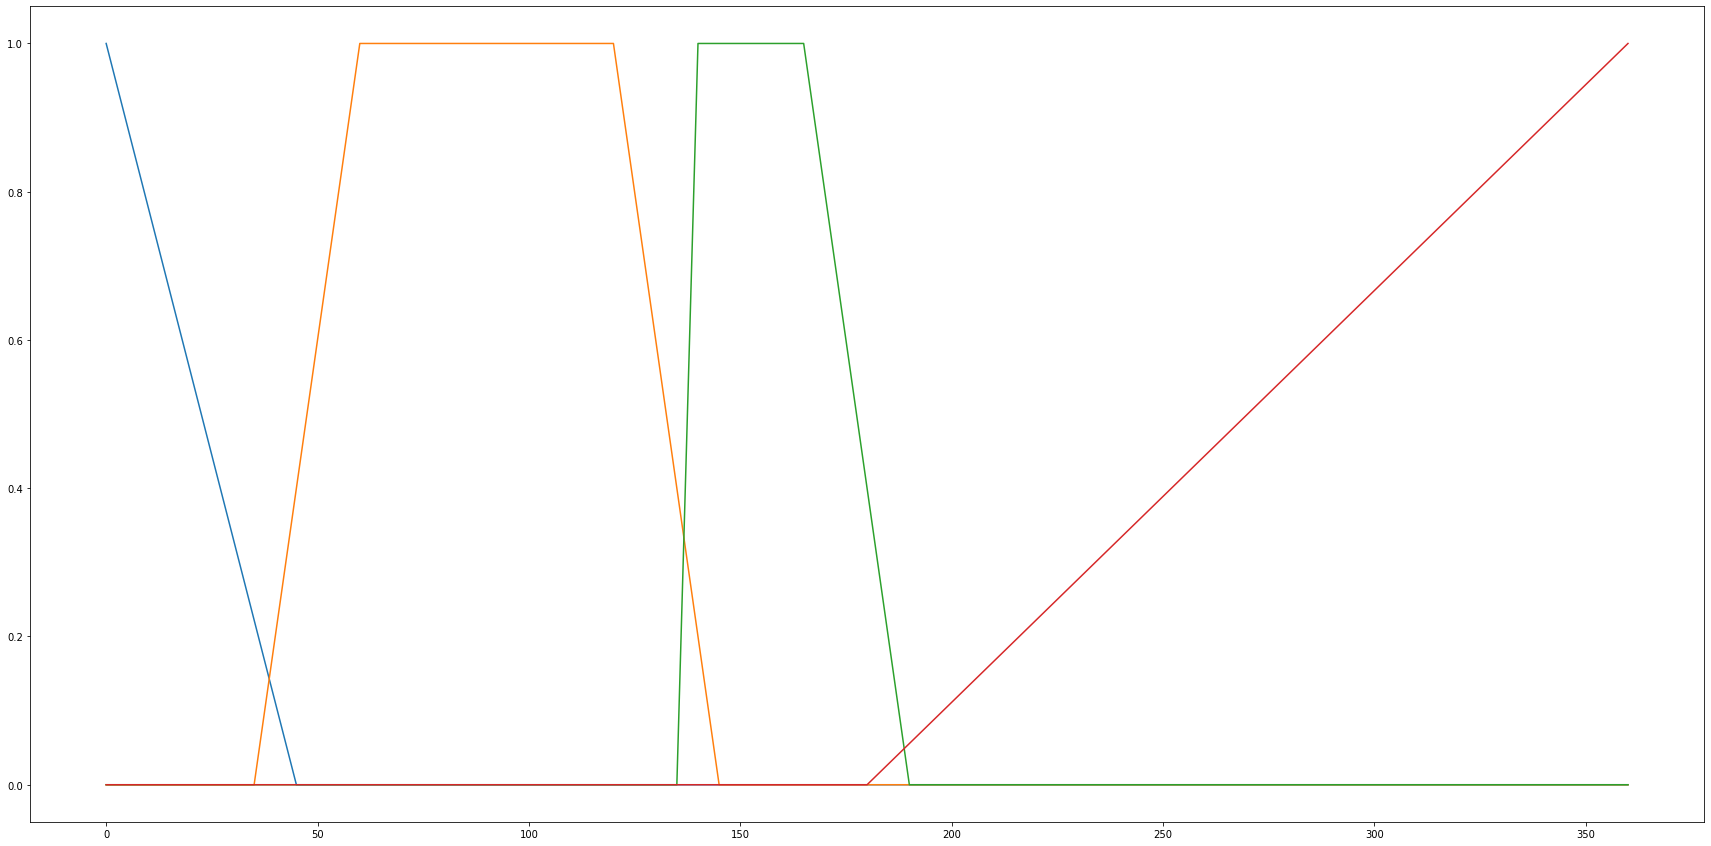

In [32]:
alpha_to_obstacle.average_danger_left_side.plot()
alpha_to_obstacle.high_danger.plot()
alpha_to_obstacle.average_danger_right_side.plot()
alpha_to_obstacle.low_danger.plot()

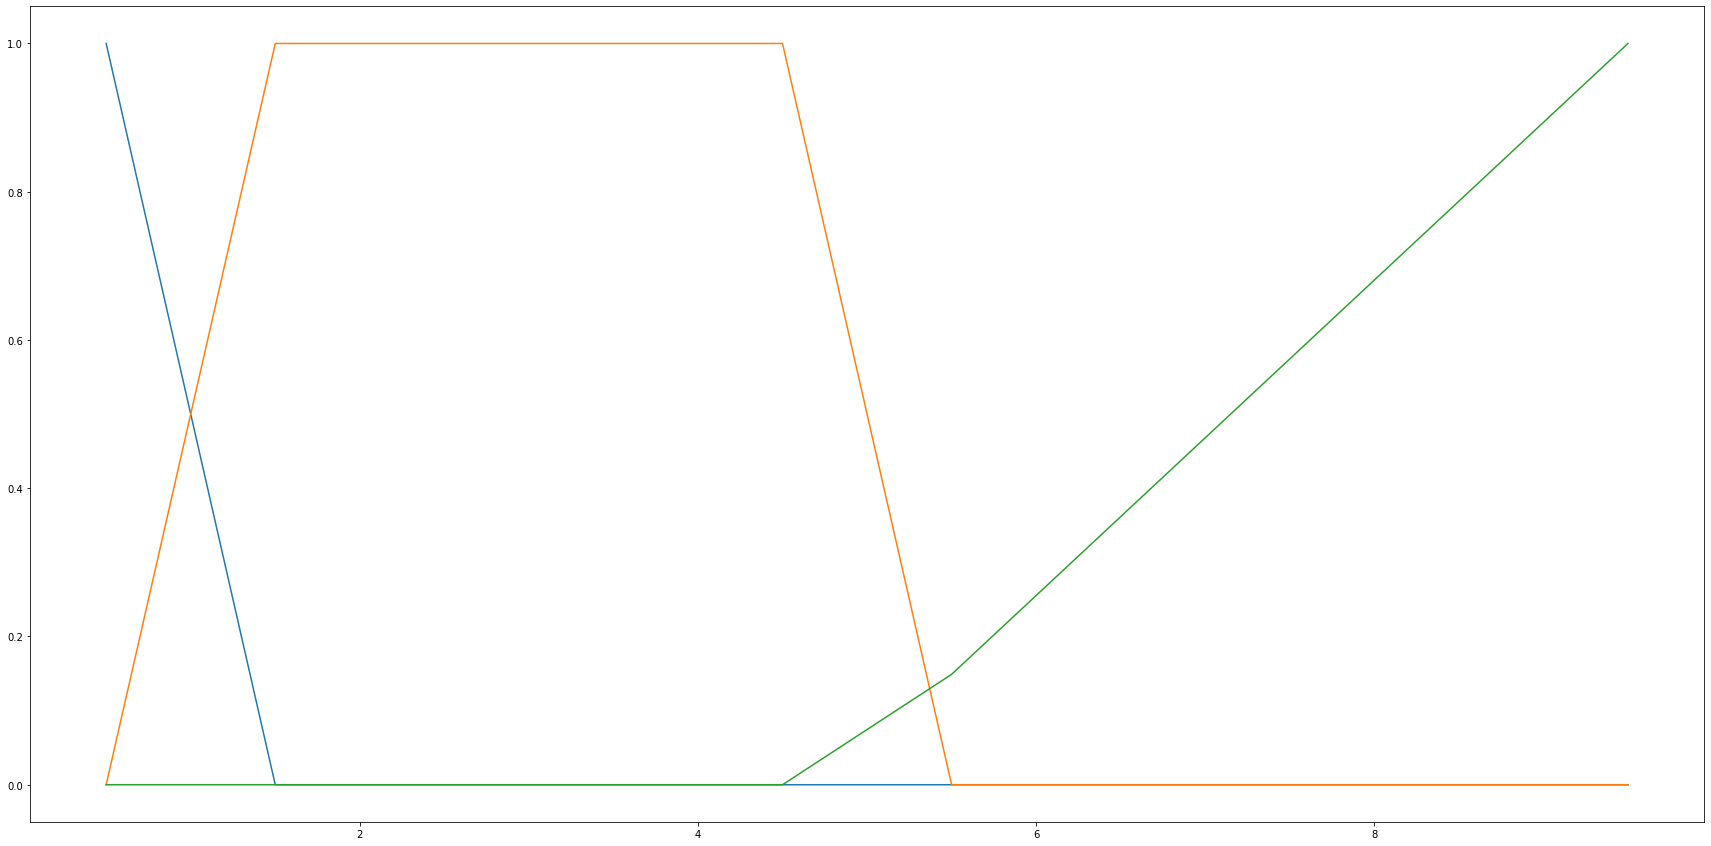

In [33]:
s.close.plot()
s.average.plot()
s.far.plot()

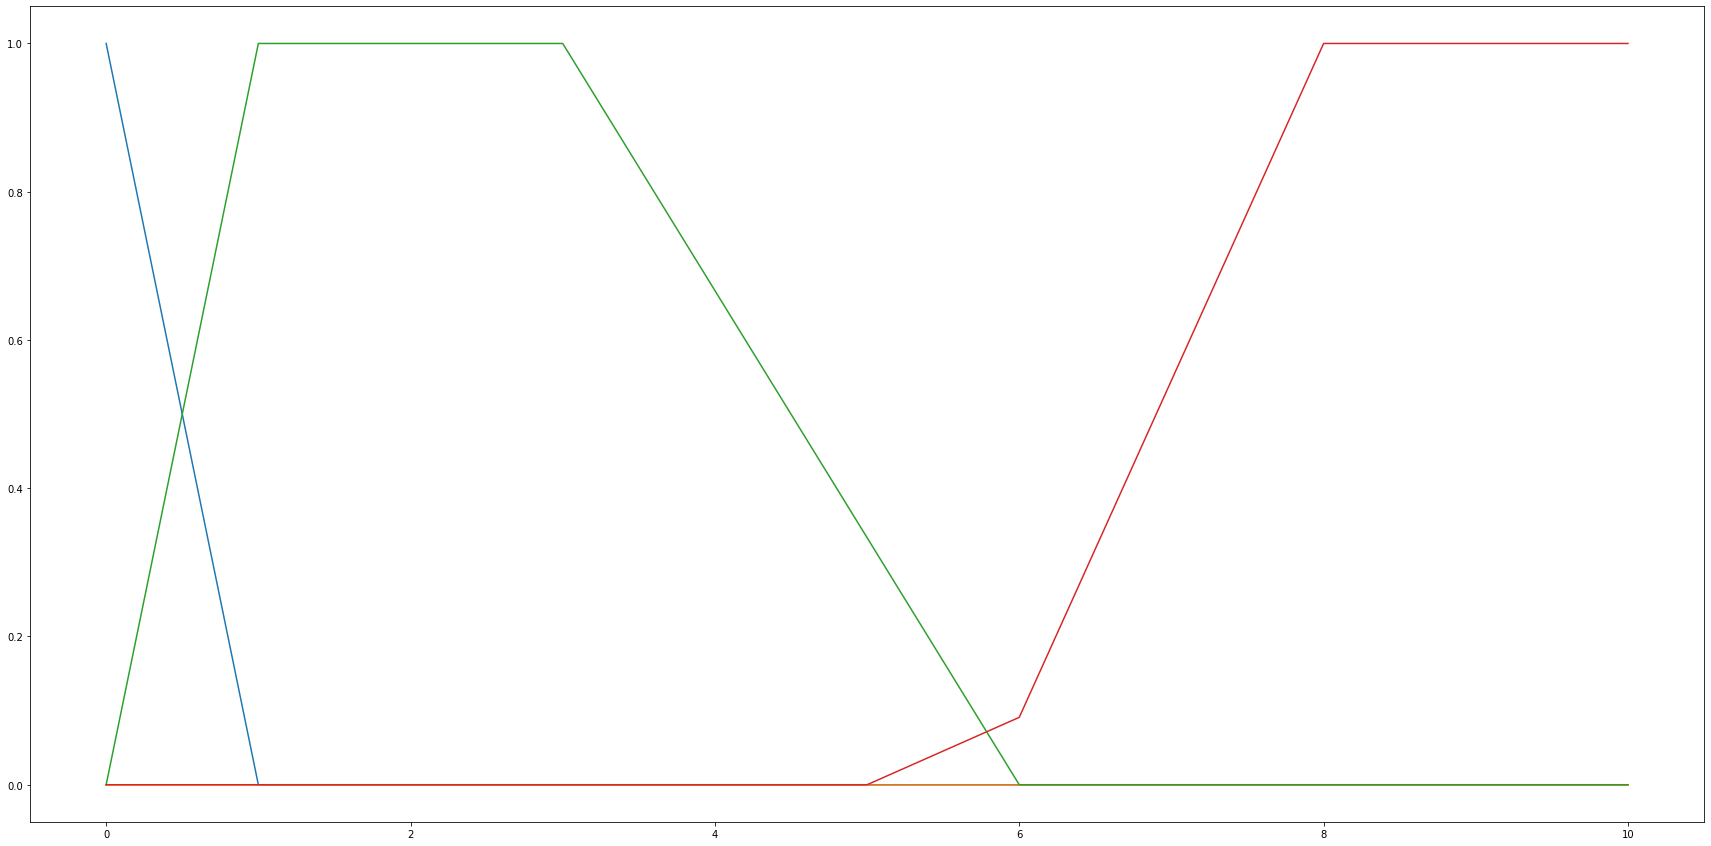

In [34]:
v.very_slow.plot()
v.slow.plot()
v.average.plot()
v.fast.plot()